# Project 5:

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from transformers import pipeline
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re

plt.style.use('dark_background')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [2]:
df = pd.read_csv('../data/global_cia_combined.csv')
# df_orig = pd.read_csv('../data/mmALL_073120_csv.csv')

In [3]:
df.head()

,country,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,...,govt_type,legal_system,gdp_purchasing_power_global_rank,gdp_growth_global_rank,electricity_access_percent,electricity_generating_capacity_global_rank,internet_access_percent,cell_phone_per_100,military_spending_annual_percent_gdp,transnational_disputes
0,Canada,1990,North America,1,1,15.0,1.0,1990.0,15.0,1.0,...,federal parliamentary democracy (Parliament of...,"common law system except in Quebec, where civi...",17.0,112.0,100.0,8.0,91.0,90.0,1.31,managed maritime boundary disputes with the US...
1,Canada,1990,North America,1,2,25.0,6.0,1990.0,25.0,6.0,...,federal parliamentary democracy (Parliament of...,"common law system except in Quebec, where civi...",17.0,112.0,100.0,8.0,91.0,90.0,1.31,managed maritime boundary disputes with the US...
2,Canada,1990,North America,1,3,1.0,7.0,1990.0,1.0,7.0,...,federal parliamentary democracy (Parliament of...,"common law system except in Quebec, where civi...",17.0,112.0,100.0,8.0,91.0,90.0,1.31,managed maritime boundary disputes with the US...
3,Canada,1990,North America,1,4,12.0,7.0,1990.0,6.0,9.0,...,federal parliamentary democracy (Parliament of...,"common law system except in Quebec, where civi...",17.0,112.0,100.0,8.0,91.0,90.0,1.31,managed maritime boundary disputes with the US...
4,Canada,1990,North America,1,5,14.0,8.0,1990.0,15.0,8.0,...,federal parliamentary democracy (Parliament of...,"common law system except in Quebec, where civi...",17.0,112.0,100.0,8.0,91.0,90.0,1.31,managed maritime boundary disputes with the US...


In [4]:
df.columns

Index(['country', 'year', 'region', 'protest', 'protestnumber', 'startday',
       'startmonth', 'startyear', 'endday', 'endmonth', 'endyear',
       'protesterviolence', 'location', 'participants', 'protesteridentity',
       'sources', 'notes', 'final', 'ignore', 'crowd dispersal', 'arrests',
       'accomodation', 'shootings', 'beatings', 'killings',
       'political behavior, process', 'labor wage dispute',
       'price increases, tax policy', 'removal of politician',
       'police brutality', 'land farm issue', 'social restrictions', 'climate',
       'natural_resources', 'population_distribution',
       'net_migration_per_1000_population', 'age_0_14_percent',
       'age_15_24_percent', 'age_25_54_percent', 'age_55_64_percent',
       'age_65_over_percent', 'language', 'govt_type', 'legal_system',
       'gdp_purchasing_power_global_rank', 'gdp_growth_global_rank',
       'electricity_access_percent',
       'electricity_generating_capacity_global_rank',
       'internet_acce

In [5]:
# extensive manual imputation, but I think it all holds up to common sense
# and I applied it consistently.  I welcome scrutiny for any mistakes.

part_dic = {"100s": 500, "1000s": 5000, "50": 50, "50+": 75, "100": 100,
            "1000": 1000, "10000": 10000, "200": 200, "2000": 2000,
            "thousands": 5000, "300": 300, "500": 500, "5000": 5000,
            "10000s": 50000, "hundreds": 500, "3000": 3000,
            "tens of thousands": 50000, "20000": 20000, "150": 150,
            "4000": 4000, "400": 400, "100000": 100000, "30000": 30000,
            "15000": 15000, "50000": 50000, "dozens": 48, "1500": 1500,
            "> 50": 75, "1000+": 1500, "6000": 6000, ">100": 150,
            "7000": 7000, "Thousands": 3000, "8000": 8000, "60": 60,
            "700": 700, "250": 250, ">1000": 1500, "600": 600,
            "Thousands": 3000, "25000": 25000, "40000": 40000,
            "Tens of thousands": 30000, "800": 800, "200000": 200000,
            "100000s": 300000, "70": 70, "2500": 2500, "10000+": 15000,
            "several thousand": 4000, "several hundred": 400,
            "hundreds of thousands": 300000, "60000": 60000, ">10000": 10000,
            "1000000": 1000000, "80": 80, "80000": 80000, "12000": 12000,
            "Hundreds": 300, "150000": 150000, "5000+": 5000, "70000": 70000,
            "300000": 300000, "2000+": 2000, ">5000": 6000, "500+": 500,
            "35000": 35000, ">300": 350, ">200": 250, "200+": 200,
            "500000": 500000, ">2000": 2500, "250000": 250000, "350": 350,
            ">3000": 3500, "10s": 50, "400000": 400000, "100000+": 100000,
            "14000": 14000, ">500": 600, "120": 120, "1300": 1300, "3500": 3500,
            "1200": 1200, "20000+": 20000, "> 10000": 10000, "3000+": 3000,
            "45000": 45000, "75": 75, ">30000": 30000, "13000": 13000,
            ">150": 150, "120000": 120000, "300+": 300, "18000": 18000,
            ">100000": 150000, "100s-1000s": 500, "600+": 650, "> 100000": 150000,
            ">50000": 60000, "800000": 800000, "16000": 16000, "350000": 350000,
            "900": 900, ">20000": 25000, "130": 130, ">400": 450, "9000": 9000,
            ">4000": 4500, "110000": 110000, ">15000": 17500,
            "400+": 400, "32000": 32000, "About 100": 100, "several hundreds": 400,
            "90000": 90000, "6000+": 6000, "1500+": 1500, "4500": 4500, "11000": 11000,
            "4000+": 4000, "700000": 700000, "170": 170, "700+": 700, "> 100": 150,
            "600000": 600000, "150+": 150, "1000000s": 3000000, "55000": 55000,
            "750000": 750000, "> 1000": 1000, "1100": 1100, "450": 450,
            "22000": 22000, "30000+": 30000, "200-300": 250,
            "hundreds of thousands": 300000, "180": 180, "scores": 60, ">250": 300,
            "Several thousand": 4000, "6500": 6500, "130000": 130000, "1500-2000": 1750,
            "55": 55, "> 3000": 3500, ">2500": 2750, "90": 90, "60+": 70,
            "> 200": 250, "17000": 17000, "240000": 240000, "280000": 280000,
            "27000": 27000, "1400": 1400, "24000": 24000, ">7000": 7500, "340": 340,
            "28000": 28000, "270": 270, ">1,000": 1500, ">700": 750, "several dozen": 48,
            "450000": 450000, "140": 140, "1700": 1700, "a few thousand": 3000,
            "1200000": 1200000, "Dozens": 36, ">300000": 350000, "> 5000": 6000,
            "66000": 66000, "<1000": 1500, ">500000": 600000, "About 200": 200,
            "5500": 5500, "> 500": 550, "more than 200": 250, ">1000000": 1500000,
            "9000+": 9000, "7500": 7500, "135000": 135000, "a few dozen": 36,
            "> 300000": 350000, "100s-10000s": 50000, "millions": 5000000,
            "> 20000": 25000, "<2000": 1500, "13000+": 13000, "61": 61,
            "Hundreds of thousands": 300000, "75000": 75000, "A few hundred": 300,
            "750": 750, "hundreds": 500, "a group": 50, "100s-1000": 500,
            "100s+": 500, ">170": 200, "3500-5000": 4000, ">5,000": 5500,
            "About 3,000": 3000, "125": 125, "100,000": 100000, "36000": 36000,
            ">600": 650, "2000000": 2000000, "Millions": 5000000, "33000": 33000,
            "<10000": 9000, "3600": 3600, "74": 74, ">150000": 160000, "260": 260,
            "100S": 500, "800+": 800, "hundreds": 500, "More than 100 people": 200,
            "10,000": 10000, "900000": 900000, "About 100 people": 100,
            "About 200 people": 200, "21000": 21000, ">2000000": 2500000,
            "3000000": 3000000, "> 400": 450, ">40000": 45000, "50 people": 50,
            ">350": 375, "1000s-10000s": 50000, "19000": 19000, "60-70": 65,
            "Hundreds of people": 500, "25000+": 25000, "15000+": 15000,
            "64+": 64, "few dozen": 36, "50000-70000": 60000, "> 30000": 35000,
            ">115": 120, "400-500": 450, "About 1000": 1000, "more than 50000": 55000,
            "> 2000": 2500, ">8000": 8500, "52000": 52000, "200,000": 200000,
            "160": 160, "<100": 90, "107": 107, "70+": 70, "61000": 61000,
            ">1100": 1200, ">80": 90, "Tens of thousands of people": 50000,
            "Thousands of people": 5000, "Crowds": 50, "102": 102, ">3100": 3200,
            "7000+": 7000, "1000s-10000": 5000, "72000": 72000, "more than 1000": 1500,
            "About 500": 500, ">35000": 37500, "<5000": 4500, "<200": 150, "115": 115,
            ">60": 65, ">6000": 6500, "50000+": 50000, "66": 66, "200000+": 200000,
            "100s-10000": 5000, "2050": 2050, "125000": 125000, "65": 65,
            ">1500": 1750, ">400000": 450000, "several dozens": 48, "2500+": 2500,
            "1000S": 5000, "500000+": 500000, "330": 330, "About 2,000 people": 2000,
            "84000": 84000, "57000": 57000, "Some 50 members": 50, "> 50000": 50000,
            "465000": 465000, "20000-40000": 30000, "10000s": 50000, "17000+": 17000,
            ">1600": 1700, "About 50": 50, "dozens arrested ": 2000000,
            "More than seven million people": 7500000, "207": 207, "7000-15000": 15000,
            "634": 634, "40": 40, "<70000": 70000, "13800": 13800, "93000": 93000,
            "At least 100": 100, "At least 10,000 people": 10000,
            "Between 11000 and 45000": 30000, ">3,000": 3500, "2,000 to 4,000 people": 3000,
            "> 3500": 3500, "about 8000": 8000, "50-99": 75, "More than 1,000 teachers": 1500,
            "4000-12000": 8000, ">50-1000": 500, "370": 370, "5600": 5600, "> 70": 80,
            "100000s-3000000": 250000, "50_": 50, "<15000": 14000, "About 10000": 10000,
            "126000": 126000, "57 former estate workers": 57, "650000": 650000, "About 120": 120,
            "240": 240, "680": 680, "86": 86, "2400+": 2400, "3300": 3300,
            "Nearly 700,000": 650000, ">440": 450, "51": 51, "25000-200000": 200000,
            ">80000": 85000, "About 30,000": 30000, "about 100": 100,
            "hundreds of thousands to 1.4 million": 900000, "Over 200 local protesters": 200,
            "14500": 14500, "> 9000": 9500, ">56": 57, "195": 195, "300-400": 350,
            "7000-9000": 8000, "137000": 137000, "up to two million": 2000000,
            "Over 3,000": 3500, "241": 241, "24000+": 24000,
            "March organiser and legal-sector lawmaker Dennis Kwok, said more than 2,000 people joined the protest. Police put the turnout at 1,700.": 1800,
            ">15,000": 16000, "128": 128, "340000": 340000, "5600+": 5600,
            "couple thousands": 2000, "840": 840, "Nearly 500": 450, "613": 613,
            "a few hundreds": 300, "About 6,000 people": 6000, "a few hundred": 300,
            "2450": 2450, "155": 155, "51000+": 51000, "About 12,000 protesters": 12000,
            "29000": 29000, "500-700": 600, "at least 500": 500, ">9000": 9500,
            "<375000": 380000, "52": 52, "35000 - 70000": 52500, "138": 138,
            "ABOUT 130 members": 130, "128000": 128000, "<1000000": 1200000,
            ">2900": 3000, "about 300": 300, "68000": 68000, "350+": 350, "About 300": 300,
            "5000-10000": 7500, "1 million": 1000000, ">70000": 75000,
            "Thousands of Indians, including Bollywood actors": 5000,
            "More than 10,000 citizens": 15000, "50s": 100, "3000-5000": 4000, "50-100": 75,
            "Around 200 protesters": 200, "at least 160000": 160000, "540": 540,
            "In northern Chiang Mai province, 200 kamnans and village heads; in Phetchaburi, about 400 kamnans and village heads": 600,
            "At least 10,000": 10000, "56000+": 56000, "15,000": 15000, ">18000": 19000,
            "Some 250 residents": 250, "4200": 4200, "btw. 20000 & 30000": 25000,
            "100s-500": 250, "few thousand": 3000, "Estimated number of protesters at 10,000" : 10000,
            "2200+" : 2200, "More than 500,000 people" : 600000, "150-300" : 225, "1000-10000" : 6000,
            "187000" : 187000, "138000" : 138000, "63000" : 63000, "161" : 161, "920" : 920,
            "13,000 people" : 13000, "56000" : 56000, "132+" : 132, "69000" : 69000, "51+" : 52,
            "busloads" : 100, "Up to 300 people": 250, "71" : 71, "106" : 106, "3000-4000" : 3500,
            "65000" : 65000, "about 3000" : 3000, "a few hundred" : 300, "About 100 taxis" : 100, 
            "500-1000" : 750, "520+" : 520, "SOME 3,000 people" : 3000, "181" : 181, 
            "100-1500+" : 1000, "700 - >1000" : 850, "Estimated 6,000 drivers" : 6000,
            "615000" : 615000, "About 50 activists" : 50, "3000 to 5000" : 4000, "<500" : 550,
            "300-1000s" : 1000, "Some 5,000 members" : 5000, "407791" : 407791, ">340" : 350,
            "298" : 298, "> 70000" : 75000, "124000" : 124000, "Some 100 residents" : 100, 
            ">200000" : 250000, "20000s" : 60000, "About 300 people" : 300, "Nearly 70 parents" : 70,
            "1500-10000" : 6000, "112" : 112, "Some 100 demonstrators" : 100, "< 100000" : 90000,
            "About 80" : 80, "More than 10,000 protesters" : 15000, "73" : 73, "800-900" : 850,
            "3000-6000" : 4500, "170000" : 170000, ">224" : 225, "<20000" : 25000, "88" : 88,
            "141" : 141, "34000" : 34000, "600-700" : 650, "1600" : 1600, "More than 1 000" : 1500,
            "200-3000" : 1600, "6000-8000" : 7000, "2,000 to 3,000" : 2500, 
            "Several thousand protesters" : 4000, "567+" : 567, ">250-300" : 300, ">370" : 380,
            "200-400" : 300, "150-200" : 175, "20000-30000" : 25000, "Over 100" : 150, 
            "10300" : 10300, "About 300 protesters" : 300, ">16000" : 16500, "2700" : 2700,
            "50000-80000" : 65000, "> 700" : 750, "Hundreds of Venezuelans" : 500, 
            "> 150000" : 160000, "5000-50000" : 30000, "193" : 193, "About 100 villagers" : 100,
            "119500" : 119500, "About 4000" : 4000, "350-400" : 375, "> 800" : 850, "223000" : 223000,
            "8000-9000" : 8500, "Some 500 people" : 500, ">459" : 460,  
            "As many as 25,000 protesters" : 25000, ">3,000" : 3500, "<300" : 350, "234" : 234,
            "more than 25000" : 26000, "23000+" : 23000, "> 40000" : 45000, "2400" : 2400, 
            "HUNDREDS OF thousands of Venezuelans" : 500000, "> 500000" : 600000, "4800" : 4800, 
            "> 400000" : 450000, "28500" : 28500, "87" : 87, "118000" : 118000, "290000" : 290000,
            "3900" : 3900, "465" : 465, "53000" : 53000, "between 35,000 and 50,000" : 42500, 
            "6600" : 6600, "1300-2000" : 1650, "510000" : 510000, ">800" : 850, 
            "About 5,000 people" : 5000, "950" : 950, "23000" : 23000, "149" : 149, "500-600" : 550,
            ">5100" : 5200, "320000" : 320000, "3700" : 3700, "1100000" : 1100000,
            "100000-200000" : 150000, "300000+" : 300000, "Thousands of miners" : 5000,
            "About 7,000" : 7000, "58000+" : 58000, "500 people" : 500, "about 2000" : 2000, 
            "14059" : 14059, "About a hundred protesters" : 100, "1500000" : 1500000, "90+" : 90,
            "500+" : 500, "Up to 100,000" : 100000, "12000+" : 12000,  "more than 2000" : 2500,
            "280" : 280, "> 200000" : 250000, "400-600+" : 500, "8500" : 8500, "2000 to 3000" : 2500, 
            "130+" : 130, "over a million" : 1000000, "<50" : 40, "180000" : 180000,
            "Hundreds of youths" : 500, "29" : 29, "<6700" : 6500, "a few thousand" : 3000,
            ">37000" : 35000, ">213" : 225, "825000" : 825000, "<200000" : 180000, "260-500" : 380,
            "12500" : 12500, ">1200" : 1250, "500-1200" : 850, "54" : 54, "17200" : 17200, 
            "> 1500" : 1600, "2600" : 2600, "> 50 < 100" : 75, "Several hundred" : 400, "311" : 311, 
            "80-100" : 90, "About 500 people" : 500, "7000000" : 7000000, "1250" : 1250, 
            "44000" : 44000, "168000" : 168000, "> 15000" : 16000, "Estimated to be 15,500" : 15500,
            "430000+" : 430000, "50-60" : 55, "650" : 650,  "80+" : 80, "79" : 79, 
            "1100-10000s" : 6500, "More than 4,000 people" : 4500, "300s" : 1000, "around 50" : 50,
            "1800+" : 1800, "> 1300" : 1350, "22800" : 22800, "Hundreds of college students" : 500,
            "A general strike that paralysed Venezuela" : 5000000, "50000-100000" : 75000,
            "300-350" : 325, "230 families" : 1000, "1000s-23000" : 18000, "40000-80000" : 60000, 
            "very low thousands" : 2000, "Several hundred demonstrators" : 400,  "> 450" : 475, 
            "484000" : 484000, "27500" : 27500, "27500" : 27500, "< 1500" : 1600, "84" : 84,
            ">2600" : 2650, ">55" : 56, "41000" : 41000, "1600+" : 1600, "1000s-40000" : 25000,
            "500,000" : 500000, "25100+" : 25100, "several 1000s" : 4000, "325000" : 325000,
            "scores (>50)" : 60, "625000" : 625000, "more than 500" : 550, ">50-100s" : 300,
            "50000-120000" : 85000, "76" : 76, "300-500" : 400, "About 2,000" : 2000,
            ">130" : 135, "2000-3000" : 2500, "5300" : 5300, "5,000,000" : 5000000, 
            "The Civil Human Rights Front said 110,000 people; The Hong Kong police said about 20,000" : 110000,
            "600-3000" : 1800, "> 50" : 60, "20700+" : 20700, "140+" : 140, 
            "More than 300 people" : 350, "270000" : 270000, "between 100000 & 300000" : 200000,
            "<400000" : 450000, "About 150 protesters" : 150, "1150" : 1150, "200-2000+" : 1500,
            "75000-170000" : 130000, "157" : 157, "Around 5,000" : 5000, ">32200" : 32250, 
            "5750" : 5750, "About 500 demonstrators" : 500, "3800" : 3800, "559" : 559, 
            "More than 30,000" : 35000, "> 60000" : 65000, "185" : 185, "2000-200000" : 105000 , 
            "Almost 350,000" : 340000, "200000-400000" : 300000, ">351" : 352, "nearly 10000" : 9000,
            "More than 200 campaigners" : 250, "Hundreds of workers" : 500, "90000+" : 90000, 
            "3000-4500" : 3750, "1800" : 1800, "1,800 participants" : 1800, "102000" : 102000,
            "1300000" : 1300000, "20000-60000" : 40000, "140000" : 140000, "65,000 people" : 65000,
            "58000" : 58000, "250+" : 250, "Nearly 500 supporters" : 475, "3200+" : 3200, 
            "500-2000" : 1250, "3765" : 3765, "70000+" : 70000, "A few hundred people" : 300,
            "Hundreds of residents" : 500, "525000" : 525000, "<900" : 850, "> 42000" : 42500,
            "6000-7000" : 6500, "570000" : 570000, "About 4,000 people" : 4000, "51000" : 51000,
            "2850" : 2850, "30000-40000" : 35000, "210" : 210, "63" : 63, ">3500" : 3600, 
            "several hundred thousands" : 400000, "> 35000" : 36000, "several thousand" : 4000,
            "2300" : 2300, "250000-350000" : 300000, "Almost 200" : 190, "3500+" : 3500, 
            "Hundreds of villagers" : 500, "18500" : 18500, "100,000s" : 500000, "6000 to 8000" : 7000,
            ">60900" : 60950, "About 400" : 400, "1365+" : 1365, "5800" : 5800, "355" : 355, 
            "about 150": 150, "250-300" : 275, "1,000,000" : 1000000, "500000-700000" : 600000,
            "Over 2,000 construction workers" : 2500, "4700+" : 4700, "> 1000000" : 1500000, 
            "4360" : 4360, "between 7500-25000" : 17500, "3000-10000" : 6500, "more than 100" : 150,
            "2200" : 2200, "82000" : 82000, "10600" : 10600, "560000" : 560000, ">280" : 285, 
            "609" : 609, "335" : 335, "388" : 388, "> 80000" : 85000, "About 50 protesters" : 50,
            "Around 300 local people" : 300, "> 23000" : 23500, "Hundreds of student protesters" : 500,
            "22500" : 22500, "260000" : 260000, "89" : 89, "17500" : 17500, ">70" : 65, "1900" : 1900,
            "The organisers said more than 3,000 people; police said the turnout was 830 at its peak" : 2000,
            "1300+" : 1300, "850" : 850, ">222" : 223, "64" : 64, "> 25000" : 25500, 
            "1,000,000s" : 5000000, "300" : 300}


## CLEANING NOTES ##
#
# any string representing an integer was transferred as-is
# "About" interpreted as "exactly"
# any integer followed by a + was interpreted as that integer
# any indication of a range was interpreted as the median point of that range
# "Up to" rounded to a reasonable "one step down" value from the provided number
# "couple" interpreted as 2, "few" as 3, "several" as 4
# "hundreds", "thousands", and "millions" interpreted as 5, 
#
# ">" rounded up to halfway to the next significant digit contextual to the given value
# "<" rounded down likewise
#
# 
#
# "100s-10000s" notes revealed two of the three entries with this description
# numbered tens of thousands, the other was unspecified.  I imputed the same value used
# for "10000s" as a result.
#
# "100s-1000" both entries were described in notes as "hundreds" so that was the value imputed.
#
# "dozens arrested " for row 2047 says nothing about the number of protestors.  From the
# wikipedia article covering this protest, I learned that "Police said that about 33,000
# participated in the protests; pro-government organizers said 175,000 demonstrated" - the
# following protest, 2 days later, "Police estimated the number at 2.4 million and organizers
# at three million, with hundreds of thousands to over a million demonstrators in São Paulo,
# about 50,000 in Brasília and thousands in other cities" - based on this I will impute a
# value of 2 million, as this entry seems to cover both days of protest.
#
# The very similar but not identical entry "dozens arrested" refers to row 11176, a protest
# in Iran.  Articles on this subject:
#     - (https://theiranproject.com/blog/2016/02/12/cancellation-of-iran-oil-contracts-presentation-signals-infighting/, )
#     - (https://www.nytimes.com/2016/02/01/world/middleeast/iran-sanctions-oil-investment.html)
# suggest a protest of moderate size.  I am setting this one to a NaN to be filled later.


df['participants'] = df['participants'].map(part_dic)

# df['participants'].value_counts(normalize=True)

In [6]:
df['participants'].fillna(500, inplace=True)

In [7]:
df['mean_age'] = 0
for i in range(0, 15193):
    df['mean_age'][i] = ((df['age_0_14_percent'][i] / 100) * 7) + ((df['age_15_24_percent'][i] / 100) * 19) + ((df['age_25_54_percent'][i] / 100) * 39) + ((df['age_55_64_percent'][i] / 100) * 59)+ ((df['age_65_over_percent'][i] / 100) * 71)

<ipython-input-7-84aa7f62ef44>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_age'][i] = ((df['age_0_14_percent'][i] / 100) * 7) + ((df['age_15_24_percent'][i] / 100) * 19) + ((df['age_25_54_percent'][i] / 100) * 39) + ((df['age_55_64_percent'][i] / 100) * 59)+ ((df['age_65_over_percent'][i] / 100) * 71)
C:\Users\catal\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [90]:
df['mean_age'].fillna(df['mean_age'].mean(), inplace=True)

In [91]:
df['beatings'].value_counts()

0    14393
1      800
Name: beatings, dtype: int64

In [94]:
df['killings'].value_counts()

827

In [93]:
df['arrests'].value_counts()

0    13048
1     2145
Name: arrests, dtype: int64

In [12]:
df['shootings'].value_counts()

0    14259
1      934
Name: shootings, dtype: int64

In [13]:
df['accomodation'].value_counts()

0    13671
1     1522
Name: accomodation, dtype: int64

In [14]:
df['ignore'].value_counts()

1    8255
0    6938
Name: ignore, dtype: int64

In [15]:
df['crowd dispersal'].value_counts()

0    10430
1     4763
Name: crowd dispersal, dtype: int64

In [16]:
df['final'].value_counts()

ignore             8209
crowd dispersal    3927
arrests            1086
accomodation        952
shootings           423
beatings            302
killings            263
0                    31
Name: final, dtype: int64

In [17]:
df['political behavior, process'].value_counts()

1    10723
0     4470
Name: political behavior, process, dtype: int64

In [18]:
df['labor wage dispute'].value_counts()

0    12990
1     2203
Name: labor wage dispute, dtype: int64

In [19]:
df['price increases, tax policy'].value_counts()

0    13782
1     1411
Name: price increases, tax policy, dtype: int64

In [20]:
df['removal of politician'].value_counts()

0    13310
1     1883
Name: removal of politician, dtype: int64

In [21]:
df['police brutality'].value_counts()

0    14097
1     1096
Name: police brutality, dtype: int64

In [22]:
df['land farm issue'].value_counts()

0    14611
1      582
Name: land farm issue, dtype: int64

In [23]:
df['social restrictions'].value_counts()

0    14511
1      682
Name: social restrictions, dtype: int64

In [24]:
(df['accomodation'] == True).sum()

1522

C:\Users\catal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


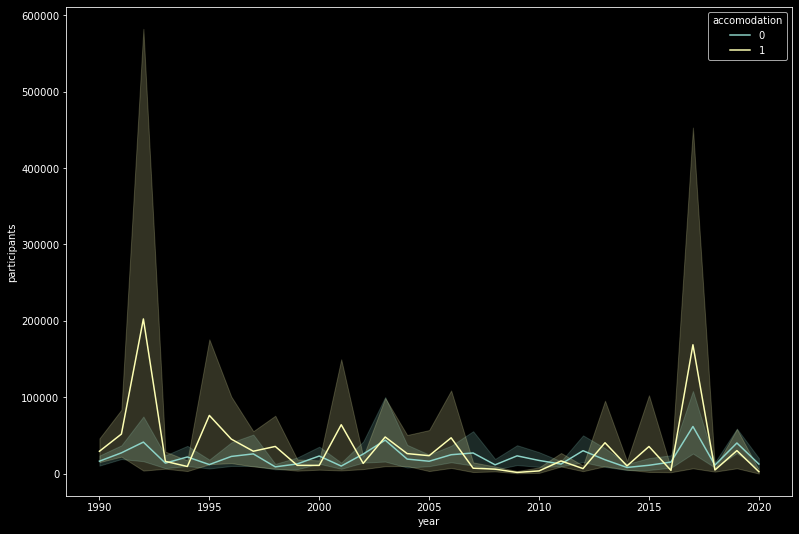

In [25]:
fig, ax = plt.subplots(figsize=(13,9))


sns.lineplot('year', 'participants', hue='accomodation',
             markers=['o','o'],
             dashes=[(1, 1), (5, 10)],
             ax=ax,
             data=df);

In [26]:
df.columns

Index(['country', 'year', 'region', 'protest', 'protestnumber', 'startday',
       'startmonth', 'startyear', 'endday', 'endmonth', 'endyear',
       'protesterviolence', 'location', 'participants', 'protesteridentity',
       'sources', 'notes', 'final', 'ignore', 'crowd dispersal', 'arrests',
       'accomodation', 'shootings', 'beatings', 'killings',
       'political behavior, process', 'labor wage dispute',
       'price increases, tax policy', 'removal of politician',
       'police brutality', 'land farm issue', 'social restrictions', 'climate',
       'natural_resources', 'population_distribution',
       'net_migration_per_1000_population', 'age_0_14_percent',
       'age_15_24_percent', 'age_25_54_percent', 'age_55_64_percent',
       'age_65_over_percent', 'language', 'govt_type', 'legal_system',
       'gdp_purchasing_power_global_rank', 'gdp_growth_global_rank',
       'electricity_access_percent',
       'electricity_generating_capacity_global_rank',
       'internet_acce

C:\Users\catal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


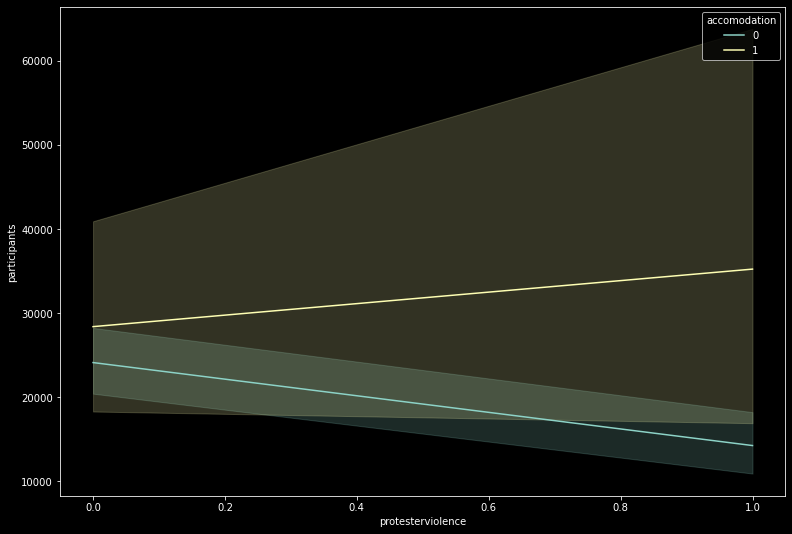

In [27]:
fig, ax = plt.subplots(figsize=(13,9))


sns.lineplot('protesterviolence', 'participants', hue='accomodation',
             markers=['o','o'],
             dashes=[(1, 1), (5, 10)],
             ax=ax,
             data=df);

C:\Users\catal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


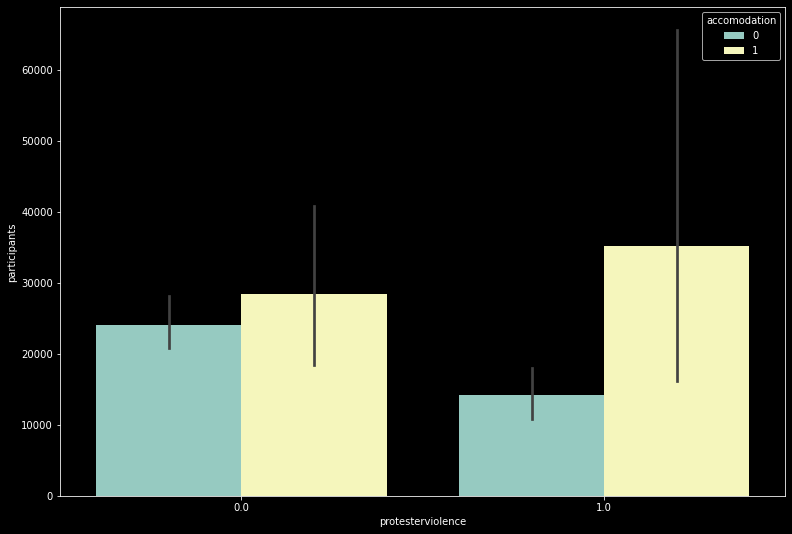

In [28]:
fig, ax = plt.subplots(figsize=(13,9))


sns.barplot('protesterviolence', 'participants', hue='accomodation',
             ax=ax,
             data=df);

In [29]:
successful = df['accomodation'] == 1
year1 = df['year'] > 2002
year2 = df['year'] < 2005
mid_00s_successes = df.loc[successful & year1 & year2]

In [30]:
mid_00s_successes['accomodation'].value_counts().sum()

92

In [31]:
mid_00s_successes['police brutality'].value_counts()

0    85
1     7
Name: police brutality, dtype: int64

In [32]:
mid_00s_successes['political behavior, process'].value_counts()

1    49
0    43
Name: political behavior, process, dtype: int64

<AxesSubplot:>

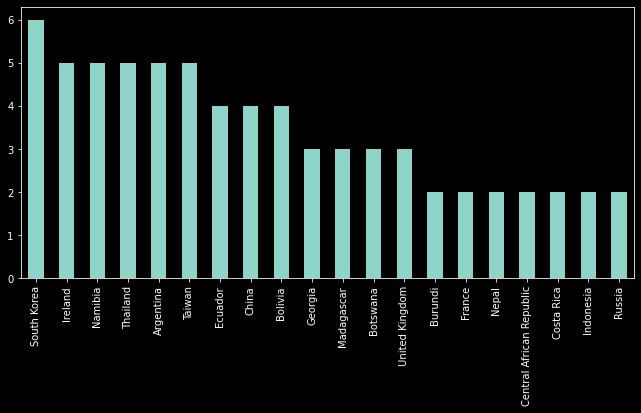

In [33]:
mid_00s_successes['country'].value_counts().head(20).plot(kind='bar', figsize=(11,5))

In [34]:
korea_protests = mid_00s_successes.loc[(mid_00s_successes['country'] == 'South Korea')]
korea_notes = korea_protests['notes']
korea_notes.iloc[4]

'thousands of angry farmers and anti war activists rallied in front of parliament monday 9 february to block the passage of the nation s first free trade agreement and a bill to send additional troops to iraq. no troops to iraq , protesters shouted as they marched, punching clenched fists into the cold winter sky. let s protect farmers livelihood by blocking imports.'

In [35]:
namib_protests = mid_00s_successes.loc[(mid_00s_successes['country'] == 'Namibia')]
namib_notes = namib_protests['notes']
namib_protests['political behavior, process']

10263    1
10264    1
10272    0
10276    1
10278    1
Name: political behavior, process, dtype: int64

In [36]:
french_protests = df.loc[(df['country'] == 'France') & (df['accomodation'] == 1) & ((df['year'] > 2002) | (df['year'] < 2005))]
french_notes = french_protests['notes']
french_notes.iloc[3]

'violent in paris only. 1 bending to pressure from a student protest movement that put more than 100,000 demonstrators onto the streets of paris today, the french government announced an emergency plan to improve conditions in the country s 4,700 senior high schools. about 150,000 students marched peacefully in dozens of other french towns and cities, but the demonstration in paris ended in confusion after gangs of troublemakers began looting stores, attacking journalists and clashing with the police in montparnasse and other left bank neighborhoods...later, the police used tear gas and water cannons to prevent groups of youths, some wearing masks and hurling stones, from crossing the river seine. at least 50 people, including 12 policemen, were wounded, and 10 cars were set on fire along the quai d orsay near the foreign ministry...student organizers had taken measures to prevent infiltration by agitators who engaged in looting during a smaller demonstration here last monday, but gang

In [37]:
def extract_tokens(max_i):
    i = 0
    note = df['notes'][i]
    tokenized_note = sent_tokenize(note.lower)
    while i <= max_i:
        print(tokenized_note)
        i += 1

In [38]:
# extract_tokens(50)

In [39]:
sent = pipeline('sentiment-analysis')

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['dropout_19', 'pre_classifier', 'classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-b

In [40]:
sent(df['notes'][0])

[{'label': 'NEGATIVE', 'score': 0.99860680103302}]

In [41]:
def sent_scorer(df, i):
    score = 0
    output = sent(df['notes'][i])
    if output[0]['label'] == 'POSITIVE':
        score = output[0]['score']
    else:
        score = (output[0]['score'] * -1)
    return score
sent_scorer(df, 5)

-0.9782278537750244

In [56]:
sent_scores = []

In [88]:
problemchildren = []
problemchildren.append(df['notes'].iloc[872])

In [89]:
problemchildren

['the hundreds of hot dog buns, bananas and containers of instant soup stacked up at the polytechnic university basketball court suggest that the young people hunkered down here are not planning to capitulate. the students and young professionals who occupied the campus last week in a nationwide protest against the government, demanding the ouster of president daniel ortega, have enough donated medical supplies to stock a field hospital. young men with t shirts covering their faces carry homemade mortar launchers as they patrol the grounds. a box of molotov cocktails sits in the corner. this is not a war; this a struggle we young people are doing, said freddy mart nez, one of the few people here who revealed his face and name. we are not left or right. we are nicaragua. the nicaraguan youth did something few people in this country thought possible. incited by an unpopular change in the social security system that would not immediately affect them, they staged a spontaneous uprising tha

In [86]:
for i in range(876, 877):
    sent_scorer(df, i)

InvalidArgumentError: Incompatible shapes: [512,768] vs. [1,625,768] [Op:BroadcastTo]

In [55]:
for i in range(0, 15193):
    sent_scores.append(sent_scorer(df, i))

In [52]:
len(df)

15193